<a href="https://colab.research.google.com/github/andy9705/stock_project/blob/main/lstm_alstm_dtml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%cd drive/MyDrive/jolproject/Adv-ALSTM

/content/drive/MyDrive/jolproject/Adv-ALSTM


In [1]:
%ls

drive/  sample_data/


In [51]:
!git clone https://github.com/fulifeng/Adv-ALSTM.git

Cloning into 'Adv-ALSTM'...
remote: Enumerating objects: 357, done.
remote: Total 357 (delta 0), reused 0 (delta 0), pack-reused 357
Receiving objects: 100% (357/357), 15.80 MiB | 7.67 MiB/s, done.
Resolving deltas: 100% (26/26), done.
Checking out files: 100% (314/314), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/MyDrive/jolproject/Adv-ALSTM/')

In [5]:
from datetime import datetime
import numpy as np
import os


def load_cla_data(data_path, tra_date, val_date, tes_date, seq=2,
                  date_format='%Y-%m-%d'):
    fnames = [fname for fname in os.listdir(data_path) if
              os.path.isfile(os.path.join(data_path, fname))]
    print(len(fnames), ' tickers selected')
    print(fnames)
    data_EOD = []
    for index, fname in enumerate(fnames):
        #print(fname)
        single_EOD = np.genfromtxt(
            os.path.join(data_path, fname), dtype=float, delimiter=',',
            skip_header=False
        )
        #print('data shape:', single_EOD.shape)
        data_EOD.append(single_EOD)
    print(len(data_EOD)) #50
    print(len(data_EOD[0])) #2518
    print(len(data_EOD[0][0])) #13


    fea_dim = data_EOD[0].shape[1] - 2

    trading_dates = np.genfromtxt(
        os.path.join(data_path, '..', 'trading_dates.csv'), dtype=str,
        delimiter=',', skip_header=False
    )
    print(len(trading_dates), 'trading dates:')

    # transform the trading dates into a dictionary with index, at the same
    # time, transform the indices into a dictionary with weekdays
    dates_index = {}
    # indices_weekday = {}
    data_wd = np.zeros([len(trading_dates), 5], dtype=float)
    wd_encodings = np.identity(5, dtype=float)
    for index, date in enumerate(trading_dates):
        dates_index[date] = index
        # indices_weekday[index] = datetime.strptime(date, date_format).weekday()
        data_wd[index] = wd_encodings[datetime.strptime(date, date_format).weekday()]

    tra_ind = dates_index[tra_date]
    val_ind = dates_index[val_date]
    tes_ind = dates_index[tes_date]
    print(tra_ind, val_ind, tes_ind) #0 2014 2266

    # count training, validation, and testing instances
    tra_num = 0
    val_num = 0
    tes_num = 0
    # training
    temp=[]
    for date_ind in range(tra_ind, val_ind):
        # filter out instances without length enough history
        if date_ind < seq:
            continue
        
        for tic_ind in range(len(fnames)):
            #print(abs(data_EOD[tic_ind][date_ind][-2]))
            
            if data_EOD[tic_ind][date_ind - seq: date_ind, :].min() > -123320:
                tra_num += 1
            else:

              temp.append([date_ind,tic_ind])
    print(temp)
    print(len(temp))
    print(tra_num, ' training instances')

    # validation
    for date_ind in range(val_ind, tes_ind):
        # filter out instances without length enough history
        if date_ind < seq:
            continue
        for tic_ind in range(len(fnames)):
            
            if data_EOD[tic_ind][date_ind - seq: date_ind, :].min() > -123320:
                val_num += 1
    print(val_num, ' validation instances')

    # testing
    for date_ind in range(tes_ind, len(trading_dates)):
        # filter out instances without length enough history
        if date_ind < seq:
            continue
        for tic_ind in range(len(fnames)):
            
            if data_EOD[tic_ind][date_ind - seq: date_ind, :].min() > -123320:
                tes_num += 1
    print(tes_num, ' testing instances')

    # generate training, validation, and testing instances
    # training
    tra_pv = np.zeros([tra_num, seq, fea_dim], dtype=float)
    tra_wd = np.zeros([tra_num, seq, 5], dtype=float)
    tra_gt = np.zeros([tra_num, 1], dtype=float)
    ins_ind = 0
    for date_ind in range(tra_ind, val_ind):
        # filter out instances without length enough history
        if date_ind < seq:
            continue
        for tic_ind in range(len(fnames)):
            
            if data_EOD[tic_ind][date_ind - seq: date_ind, :].min() > -123320:
                tra_pv[ins_ind] = data_EOD[tic_ind][date_ind - seq: date_ind, : -2]
                tra_wd[ins_ind] = data_wd[date_ind - seq: date_ind, :]
                tra_gt[ins_ind, 0] = data_EOD[tic_ind][date_ind][-2]  #ground truth
                # print(data_EOD[tic_ind][date_ind - seq: date_ind, : -2])
                # print(data_wd[date_ind - seq: date_ind, :])
                # print((data_EOD[tic_ind][date_ind][-2] + 1) / 2)
                # print(date_ind)
                
                ins_ind += 1

    # validation
    val_pv = np.zeros([val_num, seq, fea_dim], dtype=float)
    val_wd = np.zeros([val_num, seq, 5], dtype=float)
    val_gt = np.zeros([val_num, 1], dtype=float)
    ins_ind = 0
    for date_ind in range(val_ind, tes_ind):
        # filter out instances without length enough history
        if date_ind < seq:
            continue
        for tic_ind in range(len(fnames)):
            if data_EOD[tic_ind][date_ind - seq: date_ind, :].min() > -123320:
                val_pv[ins_ind] = data_EOD[tic_ind][date_ind - seq: date_ind, :-2]
                val_wd[ins_ind] = data_wd[date_ind - seq: date_ind, :]
                val_gt[ins_ind, 0] = data_EOD[tic_ind][date_ind][-2] 
                ins_ind += 1

    # testing
    tes_pv = np.zeros([tes_num, seq, fea_dim], dtype=float)
    tes_wd = np.zeros([tes_num, seq, 5], dtype=float)
    tes_gt = np.zeros([tes_num, 1], dtype=float)
    ins_ind = 0
    for date_ind in range(tes_ind, len(trading_dates)):
        # filter out instances without length enough history
        if date_ind < seq:
            continue
        for tic_ind in range(len(fnames)):
            if data_EOD[tic_ind][date_ind - seq: date_ind, :].min() > -123320:
                tes_pv[ins_ind] = data_EOD[tic_ind][date_ind - seq: date_ind, :-2]
                # # for the momentum indicator
                # tes_pv[ins_ind, -1, -1] = data_EOD[tic_ind][date_ind - 1, -1] - data_EOD[tic_ind][date_ind - 11, -1]
                tes_wd[ins_ind] = data_wd[date_ind - seq: date_ind, :]
                tes_gt[ins_ind, 0] = data_EOD[tic_ind][date_ind][-2] 
                ins_ind += 1
    return tra_pv, tra_wd, tra_gt, val_pv, val_wd, val_gt, tes_pv, tes_wd, tes_gt


def load_globalmarket_data(data_path, tra_date, val_date, tes_date, seq=2,
                  date_format='%Y-%m-%d'):
    fnames = [fname for fname in os.listdir(data_path) if
              os.path.isfile(os.path.join(data_path, fname))]
    print(len(fnames), ' tickers selected')
    print(fnames)
    data_EOD = []
    for index, fname in enumerate(fnames):
        #print(fname)
        single_EOD = np.genfromtxt(
            os.path.join(data_path, fname), dtype=float, delimiter=',',
            skip_header=False
        )
        #print('data shape:', single_EOD.shape)
        data_EOD.append(single_EOD)
    print(len(data_EOD)) #50
    print(len(data_EOD[0])) #2518
    print(len(data_EOD[0][0])) #11


    fea_dim = data_EOD[0].shape[1] 

    trading_dates = np.genfromtxt(
        os.path.join(data_path, '..', 'trading_dates.csv'), dtype=str,
        delimiter=',', skip_header=False
    )
    print(len(trading_dates), 'trading dates:')

    # transform the trading dates into a dictionary with index, at the same
    # time, transform the indices into a dictionary with weekdays
    dates_index = {}
    # indices_weekday = {}
    data_wd = np.zeros([len(trading_dates), 5], dtype=float)
    wd_encodings = np.identity(5, dtype=float)
    for index, date in enumerate(trading_dates):
        dates_index[date] = index
        # indices_weekday[index] = datetime.strptime(date, date_format).weekday()
        data_wd[index] = wd_encodings[datetime.strptime(date, date_format).weekday()]

    tra_ind = dates_index[tra_date]
    val_ind = dates_index[val_date]
    tes_ind = dates_index[tes_date]
    print(tra_ind, val_ind, tes_ind) #0 2014 2266

    # count training, validation, and testing instances
    tra_num = 0
    val_num = 0
    tes_num = 0
    # training
    
    
    for date_ind in range(tra_ind, val_ind):
        # filter out instances without length enough history
        if date_ind < seq:
            continue
        
        for tic_ind in range(len(fnames)):
            #print(abs(data_EOD[tic_ind][date_ind][-2]))
            
            if data_EOD[tic_ind][date_ind - seq: date_ind, :].min() > -123320:
                tra_num += 1
                
    print(tra_num, ' training instances')

    # validation
    for date_ind in range(val_ind, tes_ind):
        # filter out instances without length enough history
        if date_ind < seq:
            continue
        for tic_ind in range(len(fnames)):
            
            if data_EOD[tic_ind][date_ind - seq: date_ind, :].min() > -123320:
                val_num += 1
    print(val_num, ' validation instances')

    # testing
    for date_ind in range(tes_ind, len(trading_dates)):
        # filter out instances without length enough history
        if date_ind < seq:
            continue
        for tic_ind in range(len(fnames)):
            
            if data_EOD[tic_ind][date_ind - seq: date_ind, :].min() > -123320:
                tes_num += 1
    print(tes_num, ' testing instances')

    # generate training, validation, and testing instances
    # training
    tra_pv = np.zeros([tra_num, seq, fea_dim], dtype=float)
    tra_wd = np.zeros([tra_num, seq, 5], dtype=float)
    tra_gt = np.zeros([tra_num, 1], dtype=float)
    ins_ind = 0
    for date_ind in range(tra_ind, val_ind):
        # filter out instances without length enough history
        if date_ind < seq:
            continue
        for tic_ind in range(len(fnames)):
            
            if data_EOD[tic_ind][date_ind - seq: date_ind, :].min() > -123320:
                tra_pv[ins_ind] = data_EOD[tic_ind][date_ind - seq: date_ind, : ]
                tra_wd[ins_ind] = data_wd[date_ind - seq: date_ind, :]
                tra_gt[ins_ind, 0] = data_EOD[tic_ind][date_ind][-2]  #ground truth
                # print(data_EOD[tic_ind][date_ind - seq: date_ind, : -2])
                # print(data_wd[date_ind - seq: date_ind, :])
                # print((data_EOD[tic_ind][date_ind][-2] + 1) / 2)
                # print(date_ind)
                
                ins_ind += 1

    # validation
    val_pv = np.zeros([val_num, seq, fea_dim], dtype=float)
    val_wd = np.zeros([val_num, seq, 5], dtype=float)
    val_gt = np.zeros([val_num, 1], dtype=float)
    ins_ind = 0
    for date_ind in range(val_ind, tes_ind):
        # filter out instances without length enough history
        if date_ind < seq:
            continue
        for tic_ind in range(len(fnames)):
            if data_EOD[tic_ind][date_ind - seq: date_ind, :].min() > -123320:
                val_pv[ins_ind] = data_EOD[tic_ind][date_ind - seq: date_ind, :]
                val_wd[ins_ind] = data_wd[date_ind - seq: date_ind, :]
                val_gt[ins_ind, 0] = data_EOD[tic_ind][date_ind][-2] 
                ins_ind += 1

    # testing
    tes_pv = np.zeros([tes_num, seq, fea_dim], dtype=float)
    tes_wd = np.zeros([tes_num, seq, 5], dtype=float)
    tes_gt = np.zeros([tes_num, 1], dtype=float)
    ins_ind = 0
    for date_ind in range(tes_ind, len(trading_dates)):
        # filter out instances without length enough history
        if date_ind < seq:
            continue
        for tic_ind in range(len(fnames)):
            if data_EOD[tic_ind][date_ind - seq: date_ind, :].min() > -123320:
                tes_pv[ins_ind] = data_EOD[tic_ind][date_ind - seq: date_ind, :]
                # # for the momentum indicator
                # tes_pv[ins_ind, -1, -1] = data_EOD[tic_ind][date_ind - 1, -1] - data_EOD[tic_ind][date_ind - 11, -1]
                tes_wd[ins_ind] = data_wd[date_ind - seq: date_ind, :]
                tes_gt[ins_ind, 0] = data_EOD[tic_ind][date_ind][-2] 
                ins_ind += 1
    return tra_pv, tra_wd, tra_gt, val_pv, val_wd, val_gt, tes_pv, tes_wd, tes_gt

In [6]:
#from load import load_cla_data


# if 'acl18' in args.path:
#         tra_date = '2014-01-02'
#         val_date = '2015-08-03'
#         tes_date = '2015-10-01'
#     elif 'kdd17' in args.path:
#         tra_date = '2007-01-03'
#         val_date = '2015-01-02'
#         tes_date = '2016-01-04'

# tra_date = '2007-01-03'
# val_date = '2015-01-02'
# tes_date = '2016-01-04'

tra_date = '2014-01-02'
val_date = '2015-08-03'
tes_date = '2015-10-01'

tra_pv, tra_wd,tra_gt, \
val_pv, val_wd, val_gt, \
tes_pv, tes_wd, tes_gt = load_cla_data(
    "./data/stocknet-dataset/price/ourpped/",  #ACL18 ./data/stocknet-dataset/price/ourpped/, KDD ./data/kdd17/ourpped/
    tra_date, val_date, tes_date, seq=10  ##10, 15 window size
)
fea_dim = tra_pv.shape[2]

globaltra_pv, globaltra_wd,globaltra_gt, \
globalval_pv, globalval_wd, globalval_gt, \
globaltes_pv, globaltes_wd, globaltes_gt = load_globalmarket_data(
    "./data/stocknet-dataset/price/globalmarket/",  #ACL18 ./data/stocknet-dataset/price/ourpped, KDD ./data/kdd17/ourpped/
    tra_date, val_date, tes_date, seq=10  ##10, 15 window size
)


#

85  tickers selected
['AAPL.csv', 'ABBV.csv', 'AEP.csv', 'ABB.csv', 'AMGN.csv', 'AMZN.csv', 'BA.csv', 'BAC.csv', 'BCH.csv', 'BBL.csv', 'BHP.csv', 'BRK-A.csv', 'BP.csv', 'BSAC.csv', 'BUD.csv', 'C.csv', 'CAT.csv', 'CELG.csv', 'CHL.csv', 'CHTR.csv', 'CMCSA.csv', 'CODI.csv', 'CVX.csv', 'CSCO.csv', 'D.csv', 'DHR.csv', 'DIS.csv', 'EXC.csv', 'FB.csv', 'GD.csv', 'DUK.csv', 'GE.csv', 'GOOG.csv', 'HSBC.csv', 'HRG.csv', 'HON.csv', 'HD.csv', 'IEP.csv', 'JPM.csv', 'JNJ.csv', 'INTC.csv', 'KO.csv', 'LMT.csv', 'MMM.csv', 'MA.csv', 'MCD.csv', 'MDT.csv', 'MO.csv', 'MSFT.csv', 'MRK.csv', 'NEE.csv', 'NGG.csv', 'NVS.csv', 'ORCL.csv', 'PCG.csv', 'PEP.csv', 'PCLN.csv', 'PFE.csv', 'PG.csv', 'PICO.csv', 'PTR.csv', 'PM.csv', 'PPL.csv', 'RDS-B.csv', 'SNP.csv', 'SLB.csv', 'REX.csv', 'SNY.csv', 'SO.csv', 'T.csv', 'SRE.csv', 'TM.csv', 'SPLP.csv', 'TOT.csv', 'UN.csv', 'UNH.csv', 'UL.csv', 'TSM.csv', 'UPS.csv', 'UTX.csv', 'WFC.csv', 'VZ.csv', 'V.csv', 'XOM.csv', 'WMT.csv']
85
652
13
652 trading dates:
148 546 588
[]


In [46]:
len(globaltra_pv,)

(array([[-0.03624 ,  1.92064 , -0.525452,  0.895792,  0.895792,  0.978439,
          0.869724, -0.945822, -1.990395, -2.686717, -5.082441],
        [ 0.271055,  0.560177, -0.758948,  0.27179 ,  0.27179 ,  0.05421 ,
          0.914347, -0.88664 , -1.998555, -2.682327, -4.737381],
        [-0.072439,  0.452735, -1.032233, -0.21684 , -0.21684 ,  0.068814,
          1.291197, -0.231802, -1.568274, -2.218039, -3.889293],
        [-1.122989,  0.39216 , -1.693398,  1.59362 ,  1.59362 , -1.408196,
         -0.19964 , -1.292926, -2.757573, -3.546521, -4.761137],
        [ 0.682106,  0.682106, -0.125651, -0.695185, -0.695185, -0.355411,
          0.217197, -0.268054, -1.763596, -2.647279, -3.485907],
        [ 0.017934,  0.50224 , -0.44843 ,  0.071802,  0.071802, -0.22601 ,
         -0.130942, -0.171002, -1.512108, -2.425112, -3.091181],
        [-0.321658,  0.035742, -0.607577,  0.37668 ,  0.37668 , -0.378841,
         -0.716582, -0.262091, -1.583272, -2.543244, -3.196925],
        [-0.089364, 

In [7]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  if __name__ == '__main__':


In [8]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

x_train = torch.from_numpy(tra_pv).type(torch.Tensor).to(device)
x_test = torch.from_numpy(tes_pv).type(torch.Tensor).to(device)
y_train = torch.from_numpy(tra_gt).type(torch.Tensor).to(device)
y_test = torch.from_numpy(tes_gt).type(torch.Tensor).to(device)
x_val = torch.from_numpy(val_pv).type(torch.Tensor).to(device)
y_val = torch.from_numpy(val_gt).type(torch.Tensor).to(device)

global_train = torch.from_numpy(globaltra_pv).type(torch.Tensor).to(device)
global_val = torch.from_numpy(globalval_pv).type(torch.Tensor).to(device)
global_test = torch.from_numpy(globaltes_pv).type(torch.Tensor).to(device)

cuda


In [9]:
y_train.size(),x_train.size(),global_train.size()

(torch.Size([33830, 1]),
 torch.Size([33830, 10, 11]),
 torch.Size([398, 10, 11]))

In [10]:
def get_accuracy(y_true, y_prob):
    
    y_prob = y_prob > 0.0
    
    return (y_true == y_prob).sum().item() / y_true.size(0)

In [78]:
# Build model
#####################
input_dim = 11
hidden_dim = 32
num_layers = 1 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()

        #feature transformerlayer
        self.feature_transformer=nn.Linear(input_dim,input_dim)
        self.tanh_layer=nn.Tanh()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        #print(x)
        #print(x.shape)
        x=self.feature_transformer(x)
        #print(x)
        #print(x.shape)
        x=self.tanh_layer(x)
        #print(x)
        #print(x.shape)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        #print(x)
        #print(x.shape)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        #print(out.shape)  #98750, 10 ,32
        #input()
        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states!
        #print(out[:, -1, :])
        #print(out[:, -1, :].shape) #98750, 32
        #input() 
        out = self.fc(out[:, -1, :])
        #print(out)
        #print(out.shape)
        #input() 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

loss_fn = torch.nn.BCEWithLogitsLoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (feature_transformer): Linear(in_features=11, out_features=11, bias=True)
  (tanh_layer): Tanh()
  (lstm): LSTM(11, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
8
torch.Size([11, 11])
torch.Size([11])
torch.Size([128, 11])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [79]:
# Train model
#####################
num_epochs = 200
hist = np.zeros(num_epochs)
seq=10
# Number of steps to unroll
seq_dim =seq-1  

patience=15
check_early_stopping=0
val_accuracy=0
for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    model.train()
    # Forward pass
    y_train_pred = model(x_train)
    # print(y_train_pred)
    # print(y_train_pred.shape)
    # print(y_train)
    # print(y_train.shape)
    
    loss = loss_fn(y_train_pred, y_train)
    
    
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "CE: ", loss.item())
    hist[t] = loss.item()
    print(loss)
    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

    model.eval()
    correct=0
    with torch.no_grad():
      y_val_pred=model(x_val)
      #print(y_val_pred)
      #print(get_accuracy(y_val,y_val_pred))
      if val_accuracy <get_accuracy(y_val,y_val_pred):
        val_accuracy=get_accuracy(y_val,y_val_pred)
        check_early_stopping=0
      else:
        check_early_stopping=check_early_stopping+1
    if check_early_stopping==patience:
      print("early stopping!")
      print(val_accuracy)
      print("epochs: ",t)
      break
#test score
model.eval()
with torch.no_grad():
    y_test_pred=model(x_test)
    print(get_accuracy(y_test,y_test_pred))



tensor(0.6945, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6941, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6937, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6934, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6931, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6929, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6928, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6927, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6926, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6925, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Epoch  10 CE:  0.6925055384635925
tensor(0.6925, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>

In [80]:
# Build model
#####################
input_dim = 11
hidden_dim = 32
num_layers = 1 
output_dim = 1


# Here we define our model as a class
class ALSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(ALSTM, self).__init__()
        self.softmax_layer=nn.Softmax(dim=1)
        #feature transformerlayer
        self.feature_transformer=nn.Linear(input_dim,input_dim)
        self.tanh_layer=nn.Tanh()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        #print(x)
        #print(x.shape)
        x=self.feature_transformer(x)
        #print(x)
        #print(x.shape)
        x=self.tanh_layer(x)
        #print(x)
        #print(x.shape)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        #print(x)
        #print(x.shape)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        sumscore=0
        scorelist=[]
        #print(out[:,-1,:].shape)#torch.Size([98750, 32])
        #print(out[:,:,:].shape) #torch.Size([98750, 10, 32])
        
        base=out[:,-1,:].view(-1,1,self.hidden_dim)
        #print(base.shape)
        #print(base.transpose(1,2))
        #print(base.transpose(1,2).shape)
        #input()
        base=base.transpose(1,2)
        score=torch.bmm(out,base)
        #print(score.shape) #torch.Size([98750, 10, 1])
        #print(score[0])
        score = self.softmax_layer(score) #softmax score까지함 
        #print(score[0])
        #print(score.shape) #torch.Size([98750, 10, 1])
        transpose_out=out[:,:,:].transpose(1,2) #torch.Size([98750, 32, 10])
        new_out=torch.bmm(transpose_out,score)
        #print(new_out.shape)
        new_out=new_out.view(-1,self.hidden_dim)
        #print(new_out.shape)
        #input()
        # for i in range(seq):
        #   print(out[:,i,:].shape)
        #   print(base.shape)
        #   score=torch.bmm(out[:,i,:],base)
        #   print(score.shape)
        #   scorelist.append(score)
        #   sumscore=sumscore+score
        # print(scorelist)
        # print(sumscore)
        # input()
        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states!
        #print(out[:, -1, :])
        #print(out[:, -1, :].shape) 
        out = self.fc(new_out)
        
        #input() 
        # out.size() --> 100, 10
        return out
    
model = ALSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

loss_fn = torch.nn.BCEWithLogitsLoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

ALSTM(
  (softmax_layer): Softmax(dim=1)
  (feature_transformer): Linear(in_features=11, out_features=11, bias=True)
  (tanh_layer): Tanh()
  (lstm): LSTM(11, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
8
torch.Size([11, 11])
torch.Size([11])
torch.Size([128, 11])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [81]:
# Train model
#####################
num_epochs = 200
hist = np.zeros(num_epochs)
seq=10
# Number of steps to unroll
seq_dim =seq-1  

patience=15
check_early_stopping=0
val_accuracy=0
for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    model.train()
    # Forward pass
    y_train_pred = model(x_train)
    # print(y_train_pred)
    # print(y_train_pred.shape)
    # print(y_train)
    # print(y_train.shape)
    
    loss = loss_fn(y_train_pred, y_train)
    
    
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "CE: ", loss.item())
    hist[t] = loss.item()
    print(loss)
    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

    model.eval()
    correct=0
    with torch.no_grad():
      y_val_pred=model(x_val)
      #print(y_val_pred)
      #print(get_accuracy(y_val,y_val_pred))
      if val_accuracy <get_accuracy(y_val,y_val_pred):
        val_accuracy=get_accuracy(y_val,y_val_pred)
        check_early_stopping=0
      else:
        check_early_stopping=check_early_stopping+1
    if check_early_stopping==patience:
      print("early stopping!")
      print(val_accuracy)
      print("epochs: ",t)
      break
#test score
model.eval()
with torch.no_grad():
    y_test_pred=model(x_test)
    print(get_accuracy(y_test,y_test_pred))



tensor(0.6933, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6930, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6928, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6927, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6926, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6926, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6925, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6926, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6926, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6926, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Epoch  10 CE:  0.6925828456878662
tensor(0.6926, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>

In [16]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        
        
        
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout,device 
                                                  ) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        
        
    def forward(self, src):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        
        
        for layer in self.layers:
            src = layer(src)
            
        #src = [batch size, src len, hid dim]
            
        return src

class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout,device 
                 ):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout,device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        self.MLP1=nn.Linear(hid_dim,pf_dim)
        self.MLP2=nn.Linear(pf_dim,hid_dim)
        self.tanh_layer=nn.Tanh()
    def forward(self, src):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src) #_src H물결  src H
        
        #dropout, residual connection and layer norm
        t=self.MLP1(src+_src)
        t = torch.nn.functional.relu(t)
        t=self.dropout(t)
        t=self.MLP2(t)
        t=torch.nn.functional.relu(t)
        t=self.dropout(t)
        
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        src = self.tanh_layer(t+src+_src) #
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src)
        
        #src = [batch size, src len, hid dim]
        
        return src

class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout,device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        #self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        new_x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        new_x = self.fc_2(new_x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [17]:
# Build model
#####################

#the window size𝑤 in {10, 15}, the market context weight
# 𝛽 in {0.01, 0.1, 1}, the hidden layer size ℎ in {64, 128}, the number
# of epochs in {100, 200}, and the learning rate in {0.001, 0.0001}. We
# set the strength 𝜆 of selective regularization to 1 and the dropout
# rate to 0.15. We use the Adam optimizer [14] for the training with
# the early stopping by the validation accuracy. For competitors, we
# use the default settings in their public implementations.






# Here we define our model as a class
class DTML(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim,encoder):
        super(DTML, self).__init__()
        self.softmax_layer=nn.Softmax(dim=1)
        #feature transformerlayer
        self.feature_transformer=nn.Linear(input_dim,input_dim)
        self.tanh_layer=nn.Tanh()
        #self.global_train=global_train

        self.global_feature_transformer=nn.Linear(input_dim,input_dim)
        self.global_tanh_layer=nn.Tanh()

        self.layer_nomalization= nn.LayerNorm(hidden_dim)
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.stocklstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.globallstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)


        #transformer
        self.encoder=encoder
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x,numbers,global_train,beta):
        #print(numbers)
        #input()
        # Initialize hidden state with zeros
        #print(x)
        #print(x.shape)
        
        x=self.feature_transformer(x)
        #input()
        #print(x)
        #print(x.shape)
        x=self.tanh_layer(x)

        global_train=self.global_feature_transformer(global_train)
        #print(global_train)
        #print(global_train.shape)
        global_train=self.global_tanh_layer(global_train)
        
        #print(x)
        #print(x.shape) #torch.Size([98750, 10, 11])
        #input()
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        #input()
        global_h0 = torch.zeros(self.num_layers, global_train.size(0), self.hidden_dim).requires_grad_().to(device)
        global_c0 = torch.zeros(self.num_layers, global_train.size(0), self.hidden_dim).requires_grad_().to(device)
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        #print(x)
        #print(x.shape)
        out, (hn, cn) = self.stocklstm(x, (h0.detach(), c0.detach()))
        #input()
        global_out, (global_hn,global_cn) = self.globallstm(global_train,(global_h0.detach(), global_c0.detach()))

        #print(global_out.shape) #torch.Size([1975, 10, 32])

        #global market attention
        global_base=global_out[:,-1,:].view(-1,1,self.hidden_dim)
        global_base=global_base.transpose(1,2)
        global_score=torch.bmm(global_out,global_base)
        global_score = self.softmax_layer(global_score) #softmax score까지함
        global_transpose_out=global_out[:,:,:].transpose(1,2) #torch.Size([98750, 32, 10])
        global_new_out=torch.bmm(global_transpose_out,global_score)
        global_new_out=global_new_out.view(-1,self.hidden_dim)
        #print(global_new_out)
        #print(global_new_out.shape) #torch.Size([1975, 32])
        #print(len(global_new_out))
        


        sumscore=0
        scorelist=[]
        #print(out[:,-1,:].shape)#torch.Size([98750, 32])
        #print(out[:,:,:].shape) #torch.Size([98750, 10, 32])
        

        #stock attention
        base=out[:,-1,:].view(-1,1,self.hidden_dim)
        base=base.transpose(1,2)
        score=torch.bmm(out,base)
        score = self.softmax_layer(score) #softmax score까지함
        transpose_out=out[:,:,:].transpose(1,2) #torch.Size([98750, 32, 10])
        new_out=torch.bmm(transpose_out,score)
        new_out=new_out.view(-1,self.hidden_dim)
        #print(new_out)
        #print(new_out.shape) #torch.Size([98750, 32])
        #new_out=self.layer_nomalization(new_out)
        myindex=0
        for i in range(85):  #ACL 85, KDD 50
          for j in range(len(global_new_out)):
            
            
            new_out[myindex]=new_out[myindex]+global_new_out[j]*beta
            
        
        #print(new_out.shape) #torch.Size([98750, 32]) H: 50,32  W size:32x32  H를 layer 3개에 넣어서 Q,K,V를 만듦 50x32 
        #만들어야할것 98750,50,32 형태
        #print(new_out[0].shape)
        temp1=new_out[0]
        temp2=new_out[1]
        #print(temp1,temp2)
        temp3=torch.stack([temp1,temp2],0)
        #print(temp3)
        #print(temp3.shape)  #1975,50,32를 만들고 싶음
        new_data_list=[]
        #print(len(global_new_out))
        #input()
        for i in range(len(global_new_out)):
          temp=[]
          for j in range(85): #ACL 85, KDD 50
            temp.append(new_out[i+numbers*j])
          ttt=torch.stack(temp,0)  #1,50,32
          new_data_list.append(ttt)
          #Q K 내적 50x32 32x50 -> 50x50 attention map 만들고 attention map softmax 취한 후 value와 곱하면 50x32 query attention이 됨 이걸 사용해서 prediction하면됨
        #print(len(new_data_list))
        transformerdatalist=torch.stack(new_data_list,0)  #1,50,32
        #print(transformerdatalist.shape)

        my_output=encoder(transformerdatalist)
        #print(my_output)
        #print(my_output.shape) #1975,50,32
        result_list=[]
        for i in range(85):
          for j in range(len(global_new_out)):
            result_list.append(my_output[j][i])
        #print(len(result_list))
        #print(len(result_list[0]))
        new_new_out=torch.stack(result_list,0)
        #print(new_new_out.shape)
        
        out = self.fc(new_new_out)
        
        #input() 
        # out.size() --> 100, 10
        return out
    




In [13]:
print(len(x_train)//85)
print(len(x_val)//85)
print(len(x_test)//85)

398
42
64


In [1]:
for idx, (name, param) in enumerate(model.named_parameters()):
  print(idx, name, param.requires_grad)
  print(model.parameters())



NameError: ignored

In [18]:
# Train model
#####################
num_epochs = 200
hist = np.zeros(num_epochs)
seq=10
# Number of steps to unroll
seq_dim =seq-1  
beta=1
patience=200
check_early_stopping=0
val_accuracy=0
# Build model
#####################

#the window size𝑤 in {10, 15}, the market context weight
# 𝛽 in {0.01, 0.1, 1}, the hidden layer size ℎ in {64, 128}, the number
# of epochs in {100, 200}, and the learning rate in {0.001, 0.0001}. We
# set the strength 𝜆 of selective regularization to 1 and the dropout
# rate to 0.15. We use the Adam optimizer [14] for the training with
# the early stopping by the validation accuracy. For competitors, we
# use the default settings in their public implementations.
input_dim = 11

num_layers = 1 
output_dim = 1
stocknumbers=85 #stocknumbers acl 85. kdd 50
n_heads=4

dropout=0.15

beta_dir=[1] #1
hidden_list=[128 ] #128
lr_list=[0.001] #0.0001

result_dir={}

for beta in beta_dir:
  for hidden in hidden_list:
    for learningrate in lr_list:
      hidden_dim=hidden
      pf_dim=hidden_dim * 4
      encoder=Encoder(
                 input_dim, 
                 hidden_dim, 
                 1, 
                 n_heads, 
                 pf_dim,
                 dropout,
                 device, 
                 
                 max_length = 100)
      model = DTML(input_dim=input_dim, hidden_dim=hidden, output_dim=output_dim, num_layers=num_layers,encoder=encoder).to(device)

      loss_fn = torch.nn.BCEWithLogitsLoss()

      optimiser = torch.optim.Adam(model.parameters(), lr=learningrate)
      print(beta,hidden,learningrate)



      for t in range(num_epochs):
          # Initialise hidden state
          # Don't do this if you want your LSTM to be stateful
          #model.hidden = model.init_hidden()
          model.train()
          # Forward pass
          y_train_pred = model(x_train,len(x_train)//85,global_train,beta)
          # print(y_train_pred)
          # print(y_train_pred.shape)
          # print(y_train)
          # print(y_train.shape)
          print("traindata accuracy ",get_accuracy(y_train,y_train_pred))
          loss = loss_fn(y_train_pred, y_train)
          l2_lambda = 1
          # l2_norm = sum(p.pow(2.0).sum()
          #               for p in model.parameters())
          # for idx, p in enumerate(model.parameters()):
          #   if idx==34:
          #     l2_norm = p.pow(2.0).sum()
          # loss = loss + l2_lambda * l2_norm
          #print(loss)
          
          if t % 10 == 0 and t !=0:
              print("Epoch ", t, "CE: ", loss.item())
          hist[t] = loss.item()
          print(loss)
          # Zero out gradient, else they will accumulate between epochs
          optimiser.zero_grad()

          # Backward pass
          loss.backward()

          # Update parameters
          optimiser.step()

          model.eval()
          correct=0
          with torch.no_grad():
            y_val_pred=model(x_val,len(x_val)//85,global_val,beta)
            #print(y_val_pred)
            print(get_accuracy(y_val,y_val_pred))
            if val_accuracy <get_accuracy(y_val,y_val_pred):
              val_accuracy=get_accuracy(y_val,y_val_pred)
              check_early_stopping=0
            else:
              check_early_stopping=check_early_stopping+1
          if check_early_stopping==patience:
            print("early stopping!")
            print(val_accuracy)
            print("epoch: ",t)
            
            break


          #test score
          model.eval()
          with torch.no_grad():
              y_test_pred=model(x_test,len(x_test)//85,global_test,beta)
              
              print("testdata accuracy ",get_accuracy(y_test,y_test_pred))
          result_dir["beta_{}_hidden_{}_lr_{}".format(beta,hidden,learningrate)]=get_accuracy(y_test,y_test_pred)
      torch.cuda.empty_cache()

1 128 0.001
traindata accuracy  0.4904818208690511
tensor(0.7008, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
0.45854341736694676
testdata accuracy  0.5033088235294118
traindata accuracy  0.5091930239432456
tensor(0.8961, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
0.4591036414565826
testdata accuracy  0.5029411764705882
traindata accuracy  0.5091043452556903
tensor(0.7203, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
0.5470588235294118
testdata accuracy  0.48878676470588234
traindata accuracy  0.4923736328702335
tensor(0.7191, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
0.5406162464985994
testdata accuracy  0.48455882352941176
traindata accuracy  0.4911025716819391
tensor(0.7670, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
0.5406162464985994
testdata accuracy  0.48455882352941176
traindata accuracy  0.4907774164942359
tensor(0.7478, device='cu

In [16]:
print(result_dir)

{'beta_0.01_hidden_64_lr_0.001': 0.4988888888888889, 'beta_0.01_hidden_64_lr_0.0001': 0.5177777777777778, 'beta_0.01_hidden_128_lr_0.001': 0.49476190476190474, 'beta_0.01_hidden_128_lr_0.0001': 0.5284126984126984, 'beta_0.1_hidden_64_lr_0.001': 0.5308730158730158, 'beta_0.1_hidden_64_lr_0.0001': 0.4942857142857143, 'beta_0.1_hidden_128_lr_0.001': 0.5073809523809524, 'beta_0.1_hidden_128_lr_0.0001': 0.5273015873015873, 'beta_1_hidden_64_lr_0.001': 0.5311111111111111, 'beta_1_hidden_64_lr_0.0001': 0.5307142857142857, 'beta_1_hidden_128_lr_0.001': 0.5311904761904762, 'beta_1_hidden_128_lr_0.0001': 0.5053968253968254}


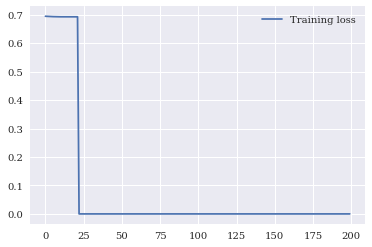

In [56]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [28]:
x = torch.LongTensor([0.2234])
y = torch.LongTensor([1])
print(torch.nn.CrossEntropyLoss(x,y))

CrossEntropyLoss()


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [14]:
np.shape(y_train_pred)

torch.Size([98750, 1])

In [54]:
%cd jolproject/Adv-ALSTM/

/content/drive/MyDrive/jolproject/Adv-ALSTM


In [66]:
import os
import pandas as pd
fnames = [fname for fname in os.listdir("./data/stocknet-dataset/price/ourpped") if
              os.path.isfile(os.path.join("./data/stocknet-dataset/price/ourpped", fname))]


# fnames = [fname for fname in os.listdir("./data/kdd17/ourpped/") if
#                os.path.isfile(os.path.join("./data/kdd17/ourpped/", fname))]


print(len(fnames))

for fname in fnames:
  temp = "./data/stocknet-dataset/price/ourpped/" + fname
  data = pd.read_csv(temp)
  print(fname,len(data))
  # for i in range(len(data)-1):
  #   if data.iloc[i,3]>0:
  #     data.iloc[i,11]=1
  #   else:
  #     data.iloc[i,11]=0
  
  
  #data.to_csv(temp,index = False)
  

87
AAPL.csv 651
ABB.csv 651
ABBV.csv 651
AEP.csv 651
AGFS.csv 651
AMGN.csv 651
AMZN.csv 651
BA.csv 651
BABA.csv 651
BAC.csv 651
BBL.csv 651
BCH.csv 651
BHP.csv 651
BP.csv 651
BRK-A.csv 651
BSAC.csv 651
BUD.csv 651
C.csv 651
CAT.csv 651
CELG.csv 651
CHL.csv 651
CHTR.csv 651
CMCSA.csv 651
CODI.csv 651
CSCO.csv 651
CVX.csv 651
D.csv 651
DHR.csv 651
DIS.csv 651
DUK.csv 651
EXC.csv 651
FB.csv 651
GD.csv 651
GE.csv 651
GOOG.csv 651
HD.csv 651
HON.csv 651
HRG.csv 651
HSBC.csv 651
IEP.csv 651
INTC.csv 651
JNJ.csv 651
JPM.csv 651
KO.csv 651
LMT.csv 651
MA.csv 651
MCD.csv 651
MDT.csv 651
MMM.csv 651
MO.csv 651
MRK.csv 651
MSFT.csv 651
NEE.csv 651
NGG.csv 651
NVS.csv 651
ORCL.csv 651
PCG.csv 651
PCLN.csv 651
PEP.csv 651
PFE.csv 651
PG.csv 651
PICO.csv 651
PM.csv 651
PPL.csv 651
PTR.csv 651
RDS-B.csv 651
REX.csv 651
SLB.csv 651
SNP.csv 651
SNY.csv 651
SO.csv 651
SPLP.csv 651
SRE.csv 651
T.csv 651
TM.csv 651
TOT.csv 651
TSM.csv 651
UL.csv 651
UN.csv 651
UNH.csv 651
UPS.csv 651
UTX.csv 651
V.csv 651

In [ ]:
t=set()
for i in range(len(data)):
  t.add(data.iloc[i][11])
print(t)

{0.0, 1.0, -123321.0}


In [ ]:
k=set()
for fname in fnames:
  temp = "./data/kdd17/ourpped/" + fname
  print(temp)
  data = pd.read_csv(temp,index_col=0)
  print(data)
  print(data.iloc[:,11])
  break

./data/kdd17/ourpped/AAPL.csv
            -123321.000000  -123321.000000.1  -123321.000000.2  \
Unnamed: 0                                                       
0           -123321.000000    -123321.000000    -123321.000000   
1           -123321.000000    -123321.000000    -123321.000000   
2           -123321.000000    -123321.000000    -123321.000000   
3           -123321.000000    -123321.000000    -123321.000000   
4           -123321.000000    -123321.000000    -123321.000000   
...                    ...               ...               ...   
2512             -0.798147          0.000000         -0.798147   
2513             -0.631080          0.460516         -0.656664   
2514              0.650904          1.079132         -0.479621   
2515             -0.239875          0.325536         -0.282705   
2516              0.716631          1.191501         -0.336729   

            -123321.000000.3  -123321.000000.4  -123321.000000.5  \
Unnamed: 0                                 

In [20]:
# if 'acl18' in args.path:
#         tra_date = '2014-01-02'
#         val_date = '2015-08-03'
#         tes_date = '2015-10-01'
#     elif 'kdd17' in args.path:
#         tra_date = '2007-01-03'
#         val_date = '2015-01-02'
#         tes_date = '2016-01-04'

#s&p 500 데이터 추출
# tra_date = '2007-01-03'
# val_date = '2015-01-02'
# tes_date = '2016-01-04'


tra_date = '2014-01-02'
val_date = '2015-08-03'
tes_date = '2015-10-01'
#end date 2016-12-31
import pandas_datareader.data as web
from matplotlib.pyplot import imshow

sp500 = web.DataReader('^GSPC', data_source='yahoo', start='6/3/2013', end='12/31/2015')

In [2]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 504 entries, 2014-01-02 to 2015-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       504 non-null    float64
 1   Low        504 non-null    float64
 2   Open       504 non-null    float64
 3   Close      504 non-null    float64
 4   Volume     504 non-null    int64  
 5   Adj Close  504 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 27.6 KB


In [21]:
sp500

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2013-06-03,1640.420044,1622.719971,1631.709961,1640.420044,3952070000,1640.420044
2013-06-04,1646.530029,1623.619995,1640.729980,1631.380005,3653840000,1631.380005
2013-06-05,1629.310059,1607.089966,1629.050049,1608.900024,3632350000,1608.900024
2013-06-06,1622.560059,1598.229980,1609.290039,1622.560059,3547380000,1622.560059
2013-06-07,1644.400024,1625.270020,1625.270020,1643.380005,3371990000,1643.380005
...,...,...,...,...,...,...
2015-12-24,2067.360107,2058.729980,2063.520020,2060.989990,1411860000,2060.989990
2015-12-28,2057.770020,2044.199951,2057.770020,2056.500000,2492510000,2056.500000
2015-12-29,2081.560059,2060.540039,2060.540039,2078.360107,2542000000,2078.360107


In [22]:
sp500['zopen']=sp500['Open']/sp500['Close'] -1
sp500['zhigh']=sp500['High']/sp500['Close'] -1
sp500['zlow']=sp500['Low']/sp500['Close']-1

In [23]:
sp500['zclose']=-123320
sp500['zadjclose']=-123320
sp500['z5']=-123320
sp500['z10']=-123320
sp500['z15']=-123320
sp500['z20']=-123320
sp500['z25']=-123320
sp500['z30']=-123320

In [24]:
len(sp500)

652

In [25]:
for i in range(1,len(sp500)):
  sp500.iloc[i,9]=sp500.iloc[i,3]/sp500.iloc[i-1,3] -1

In [26]:
for i in range(1,len(sp500)):
  sp500.iloc[i,10]=sp500.iloc[i,5]/sp500.iloc[i-1,5] -1

In [27]:
for i in range(4,len(sp500)):
  mysum=0
  for j in range(5):
    mysum=mysum+sp500.iloc[i-j,5]
  sp500.iloc[i,11]=mysum/(5*sp500.iloc[i,5]) -1

In [28]:
for i in range(9,len(sp500)):
  mysum=0
  for j in range(10):
    mysum=mysum+sp500.iloc[i-j,5]
  sp500.iloc[i,12]=mysum/(10*sp500.iloc[i,5]) -1

for i in range(14,len(sp500)):
  mysum=0
  for j in range(15):
    mysum=mysum+sp500.iloc[i-j,5]
  sp500.iloc[i,13]=mysum/(15*sp500.iloc[i,5]) -1

for i in range(19,len(sp500)):
  mysum=0
  for j in range(20):
    mysum=mysum+sp500.iloc[i-j,5]
  sp500.iloc[i,14]=mysum/(20*sp500.iloc[i,5]) -1

for i in range(24,len(sp500)):
  mysum=0
  for j in range(25):
    mysum=mysum+sp500.iloc[i-j,5]
  sp500.iloc[i,15]=mysum/(25*sp500.iloc[i,5]) -1

for i in range(29,len(sp500)):
  mysum=0
  for j in range(30):
    mysum=mysum+sp500.iloc[i-j,5]
  sp500.iloc[i,16]=mysum/(30*sp500.iloc[i,5]) -1

In [29]:
new_sp500 = sp500.iloc[:,6:]

In [30]:
new_sp500.iloc[28]

zopen            -0.002934
zhigh             0.000000
zlow             -0.004678
zclose            0.003086
zadjclose         0.003086
z5               -0.011944
z10              -0.024918
z15              -0.033711
z20              -0.033206
z25              -0.032273
z30         -123320.000000
Name: 2013-07-12 00:00:00, dtype: float64

In [31]:
new_sp500.iloc[:29,:]=-123320

In [32]:
new_sp500.iloc[29]

zopen       -0.001730
zhigh        0.001195
zlow        -0.002740
zclose       0.001375
zadjclose    0.001375
z5          -0.008303
z10         -0.021727
z15         -0.031469
z20         -0.032876
z25         -0.032671
z30         -0.032493
Name: 2013-07-15 00:00:00, dtype: float64

In [33]:
new_sp500.to_csv('sp500_acl18.csv', header=False, index=False)

In [27]:
%ls

drive/  sample_data/


In [19]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 8.2 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0
